In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from scipy import sparse
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import string
from tqdm import tqdm, tqdm_notebook
import pickle

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from itertools import product
from collections import Counter
import operator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

tqdm.pandas()

In [2]:
%%time
chunks = pd.read_csv('Train.csv', chunksize=180000, iterator=True)
data = pd.DataFrame()
for chunk in chunks:
    data = pd.concat((data, chunk))
    break
data = data.sample(10000, random_state=42)

Wall time: 2.79 s


In [3]:
data.groupby(['Tags']).size().head()

Tags
.htaccess                   1
.htaccess apache2           1
.htaccess dns               1
.htaccess mod-rewrite       1
.htaccess redirect https    1
dtype: int64

In [4]:
data.head()

Id                                              Title  \
123137  123138           The composition of stable maps is stable   
130504  130505          go back 1 view in UINavigationController?   
31166    31167    Where should logging occur in an MVC framework?   
26262    26263  Silverlight authentication during startup - ho...   
64868    64869      Bluetooth MAC Address reading from iOS device   

                                                     Body  \
123137  <p>If $G$ acts on $X,Y,Z$ and if $f: X \righta...   
130504  <p>Is there a method to go back 1 view in the ...   
31166   <p>I've been doing, or at least trying, to do ...   
26262   <p>I have a Silverlight app that is using the ...   
64868   <p>I need to know the Bluetooth MAC address of...   

                                       Tags  
123137                         group-theory  
130504  iphone objective-c cocoa-touch ipad  
31166                      java mvc logging  
26262           silverlight silverlight-4.0  
64868      iphone ios osx bluetooth address

In [5]:
%%time
print(data.shape)
data.drop_duplicates(inplace=True)
print(data.shape)

(10000, 4)
(10000, 4)
Wall time: 58.8 ms


In [6]:
data[data['Tags'].isna()]

Empty DataFrame
Columns: [Id, Title, Body, Tags]
Index: []

In [8]:
def plot_scores(optimal_model, param):
    _, = plt.plot(list(optimal_model.cv_results_[f'param_{param}']), \
                      list(optimal_model.cv_results_['mean_train_score']), 'g-', \
                     label='Training Scores')
    _, = plt.plot(list(optimal_model.cv_results_[f'param_{param}']), \
                      list(optimal_model.cv_results_['mean_test_score']), 'r-', \
                      label='Test Scores')
    _, = plt.plot(optimal_model.best_params_[param], optimal_model.best_score_, 'bo', \
            label=f"Optimal Value ({param}={optimal_model.best_params_[param]}, Score={round(optimal_model.best_score_,2)})")

    plt.xlabel(param)
    plt.ylabel('Scores')
    plt.legend()
    plt.show()

In [9]:
%%time
# Utility Functions for Text Pre-processing
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def preprocess(text_data):
    text_data = re.sub(r'<code>(.*?)</code>', '', text_data, flags=re.MULTILINE|re.DOTALL)
    
    def striphtml(raw_data):
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, ' ', str(raw_data))
        cleantext = re.sub('http\s*.*?\s', '', cleantext)
        return cleantext

    text = striphtml(text_data)
    tokens = word_tokenize(text.lower())
    
    # Handling C# and F# programming languages
    for i in range(len(tokens)-1):
        if tokens[i] == 'c' or tokens[i] == 'f':
            if tokens[i+1] == '#':
                tokens[i] += '#'

    taggd = []
    for x,y in tqdm(pos_tag(tokens)):
        if y == 'VBP' or y == 'JJ' or y.startswith('NN'):
            if (x not in string.punctuation) and (x not in stop_words) and (not x.startswith("'")):
                if len(x) < 2 and (x not in ['c', 'r']):
                    continue
                else:
                    taggd.append(stemmer.stem(x))

    return ' '.join(set(taggd))

Wall time: 2 ms


In [10]:
%%time
# Feature Engineering
data['Code'] = data.progress_apply(lambda row: str(re.findall(r'<code>(.*?)</code>', row['Body'], flags=re.DOTALL)), axis=1)
data['Text_Title'] = data['Title'].apply(preprocess)
data['Text_Body'] = data['Body'].apply(preprocess)
data['Text'] = data.progress_apply(lambda row: ' '.join(((row['Text_Title'] * 3) + ' ' + row['Text_Body']).split()), axis=1)
data['Title_Length'] = data['Title'].progress_apply(len)
data['Body_Length'] = data['Body'].progress_apply(len)
data['#_Words'] = data['Text'].progress_apply(lambda row: len(row.split()))
data['#_Codes'] = data['Code'].progress_apply(len)
data['Code_type1'] = data['Code'].progress_apply(lambda x: 1 if '#include ' in x else 0)
data['Code_type2'] = data['Code'].progress_apply(lambda x: 1 if 'throws ' in x else 0)
data['Code_type3'] = data['Code'].progress_apply(lambda x: 1 if 'System.out.print ' in x else 0)
data['Code_type4'] = data['Code'].progress_apply(lambda x: 1 if 'import ' in x else 0)
data['Code_type5'] = data['Code'].progress_apply(lambda x: 1 if 'void main' in x else 0)
data['Code_type6'] = data['Code'].progress_apply(lambda x: 1 if 'select' in x else 0)
data['Code_type7'] = data['Code'].progress_apply(lambda x: 1 if 'GroupBy' in x else 0)

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7027.32it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3010.99it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5021.92it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5003.94it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4015.61it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8002.49it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12018.06it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11040.28it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 6940.93it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16024.08it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16047.07it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7029.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6016.21it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8019.70it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8015.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10029.42it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5015.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11040.28it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 9030.80it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 14034.48it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6027.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8023.54it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11037.64it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4008.89it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7020.59it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 6995.50it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6021.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5012.31it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7012.21it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8021.62it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 78513.74it/s]


100%|████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 151408.06it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 89709.69it/s]


100%|████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 199680.98it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40041.09it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 79204.02it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 14024.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 63648.78it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 51602.16it/s]


100%|████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 113359.57it/s]


100%|████████████████████████████████████████████████████████████████████████████| 171/171 [00:00<00:00, 171708.40it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 50630.42it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 34108.19it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 74146.80it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 75166.74it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 84267.29it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 64295.92it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 73214.78it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 458/458 [00:00<00:00, 91909.06it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████| 110/110 [00:00<00:00, 110112.99it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 76223.60it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 67722.88it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 98825.25it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 36105.92it/s]


100%|████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 108214.25it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 104305.98it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 68347.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 21071.86it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 78266.92it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 55649.98it/s]


100%|████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 118304.74it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 86253.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 148364.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 55596.82it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 29590.33it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 98147.51it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 64172.95it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 210769.05it/s]


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100366.21it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 56171.48it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79175.63it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 83363.80it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 93340.58it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 52115.61it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 91050.02it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 44150.57it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 87235.11it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 63200.47it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 73249.81it/s]


100%|████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 106311.87it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 65669.16it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 47093.24it/s]


100%|████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 137452.37it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32117.19it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 42113.50it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 62063.69it/s]


100%|████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 112437.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 47104.49it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 92270.68it/s]


100%|████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 181619.38it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 34116.35it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 96075.68it/s]


100%|████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 150333.48it/s]


100%|████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 109216.23it/s]


100%|████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 183714.13it/s]


100%|████████████████████████████████████████████████████████████████████████████| 409/409 [00:00<00:00, 136767.15it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 45617.50it/s]


100%|████████████████████████████████████████████████████████████████████████████| 481/481 [00:00<00:00, 120517.34it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17033.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 129441.44it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 35061.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 99172.70it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30081.07it/s]


100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 501417.11it/s]


Wall time: 3min 28s


In [13]:
data.head(2)

Id                                      Title  \
123137  123138   The composition of stable maps is stable   
130504  130505  go back 1 view in UINavigationController?   

                                                     Body  \
123137  <p>If $G$ acts on $X,Y,Z$ and if $f: X \righta...   
130504  <p>Is there a method to go back 1 view in the ...   

                                       Tags Code                Text_Title  \
123137                         group-theory   []        stabl map composit   
130504  iphone objective-c cocoa-touch ipad   []  uinavigationcontrol view   

                                                Text_Body  \
123137  attempt equal fg \rightarrow \in h.gf proof hx...   
130504  specif stack view uinavigationcontrol method titl   

                                                     Text  Title_Length  \
123137  stabl map compositstabl map compositstabl map ...            40   
130504  uinavigationcontrol viewuinavigationcontrol vi...            41   

        Body_Length  #_Words  #_Codes  Code_type1  Code_type2  Code_type3  \
123137          330       21        2           0           0           0   
130504          122       10        2           0           0           0   

        Code_type4  Code_type5  Code_type6  Code_type7  
123137           0           0           0           0  
130504           0           0           0           0

In [14]:
%%time
# Data split into Train-Test
split = 0.8
data_train = data[:int(split * data.shape[0])].reset_index(drop=True)
data_test = data[int(split * data.shape[0]):].reset_index(drop=True)

print(data_train.shape, data_test.shape)

(8000, 19) (2000, 19)
Wall time: 16 ms


In [15]:
%%time
# Building Associations/Probablity of Tags from Words/Tokens obtained from 'Training Data' only.
sim_pairs = []
words = Counter()
for index, row in data.iterrows():
    for x, y in product(row['Text'].split(), row['Tags'].split()):
        sim_pairs.append((x,y))
        words[x] += 1
sim_pairs = Counter(sim_pairs)

associations = []
for key, value in sim_pairs.items():
    associations.append((key[0], key[1], value/words[key[0]])) # Token, Tag, Probability (Frequency of Token-Tag / Frequency of Token)
associations = pd.DataFrame(associations, columns=['Token', 'Tag', 'Probability'])
associations.set_index(['Token', 'Tag'], inplace=True)

Wall time: 2.12 s


In [16]:
%%time
def get_tags(text_data):
    # word_probas contains the summed probabilities above a certain threshold of all the Tags for all the words in Query Text
    word_probas = Counter()
    for word in text_data.split():
        try:
            for index, row in associations.loc[word].sort_values('Probability', ascending=False)[:5].iterrows():
                if row['Probability'] > 0.20:
                    word_probas[index] += row['Probability']
        except KeyError:
            #print(word)
            pass
    words = [word for word,prob in word_probas.most_common(5)]
    return words

predicted_train = []
for index,row in data_train.iterrows():
    if (index % 5000) == 0:
        print(f'Running {index} row in Train Data...')
    predicted_train.append(' '.join(get_tags(row['Text'])))

predicted_test = []
for index,row in data_test.iterrows():
    if (index % 5000) == 0:
        print(f'Running {index} row in Test Data...')
    predicted_test.append(' '.join(get_tags(row['Text'])))
    
print('\nGiven Title vs Predicted Tags :-')
print(list(zip(data_test['Title'].iloc[:5], predicted_test[:5])))

Running 0 row in Train Data...
Running 5000 row in Train Data...
Running 0 row in Test Data...

Given Title vs Predicted Tags :-
[('Trigger a Partial Page Refresh from backing bean in Oracle ADF', 'oracle java jdeveloper partial-page-refresh'), ('How can I detect that a file descriptor was redefined to a new filehandle?', 'multithreading perl'), ('What is a simple file compare tool? (equal or not)', 'windows-7 file comparison'), ('Date conversion in Xquery', 'date xquery'), ('SpatialSearch with apache solr, I am importing data from mysql', 'mysql solr apache number-theory mylyn')]
Wall time: 20min 21s


In [17]:
%%time
data_train['Predicted_Tag'] = pd.Series(predicted_train)
data_train['Predicted_Tag'].fillna(value='Other', inplace=True)

data_test['Predicted_Tag'] = pd.Series(predicted_test)
data_test['Predicted_Tag'].fillna(value='Other', inplace=True)

Wall time: 2.99 ms


In [18]:
%%time
x_train = data_train['Text']
x_test = data_test['Text']

y_train = data_train['Tags']
y_test = data_test['Tags']

Wall time: 0 ns


In [19]:
%%time
vect = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
actual_tags_train = vect.fit_transform(data_train['Tags'])
actual_tags_test = vect.transform(data_test['Tags'])

Wall time: 46.9 ms


In [20]:
%%time
pred_tags_train = vect.transform(data_train['Predicted_Tag'])
pred_tags_test = vect.transform(data_test['Predicted_Tag'])

print(pred_tags_train.shape, pred_tags_test.shape)

(8000, 5419) (2000, 5419)
Wall time: 37.9 ms


In [21]:
%%time
f1 = f1_score(actual_tags_test, pred_tags_test, average='micro')
print(f1)

0.8157093765341188
Wall time: 5.96 ms


In [22]:
%%time
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=15000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1, 3))
# vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), max_features=20000, min_df=0.00009, binary=True)
x_train = vectorizer.fit_transform(x_train.values)
x_test = vectorizer.transform(x_test.values)
print(x_train.shape, x_test.shape)

sc = StandardScaler()
data_train['Title_Length'] = sc.fit_transform(data_train['Title_Length'].reshape(-1, 1))
data_test['Title_Length'] = sc.transform(data_test['Title_Length'].reshape(-1, 1))
data_train['Body_Length'] = sc.fit_transform(data_train['Body_Length'].reshape(-1, 1))
data_test['Body_Length'] = sc.transform(data_test['Body_Length'].reshape(-1, 1))
data_train['#_Words'] = sc.fit_transform(data_train['#_Words'].reshape(-1, 1))
data_test['#_Words'] = sc.transform(data_test['#_Words'].reshape(-1, 1))
data_train['#_Codes'] = sc.fit_transform(data_train['#_Codes'].reshape(-1, 1))
data_test['#_Codes'] = sc.transform(data_test['#_Codes'].reshape(-1, 1))


x_train = sparse.hstack([x_train, pred_tags_train, data_train[['Title_Length', 'Body_Length', '#_Words', '#_Codes']]])
x_test = sparse.hstack([x_test, pred_tags_test, data_test[['Title_Length', 'Body_Length', '#_Words', '#_Codes']]])

print(x_train.shape, x_test.shape)

(8000, 15000) (2000, 15000)
(8000, 20423) (2000, 20423)
Wall time: 2.04 s


In [23]:
%%time
parameters = {'estimator__C':(0.0001, 0.001, 0.01, 1.0, 10.0),
             'estimator__penalty':('l1', 'l2')}
ovr_model = OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=20))
classifier = RandomizedSearchCV(ovr_model, param_distributions=parameters, cv=2, scoring='f1_micro', \
                          n_jobs=-1, verbose=3, refit=True, n_iter=5)
classifier.fit(x_train, actual_tags_train)
predictions = classifier.predict(x_test)

f1 = f1_score(actual_tags_test, predictions, average='micro')
print(f'F1-score: {f1}')
acc = accuracy_score(actual_tags_test, predictions)
print(f'Accuracy: {acc}')

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.4min finished


F1-score: 0.7377740303541316
Accuracy: 0.4045
Wall time: 13min 48s


In [24]:
%%time
print(f1_score(actual_tags_train, classifier.predict(x_train), average='micro'))

0.998882441435633
Wall time: 1min 2s



F1_Score of the Optimal Classifier with parameters-{'estimator__penalty': 'l1', 'estimator__C': 10.0} is 63.11 %


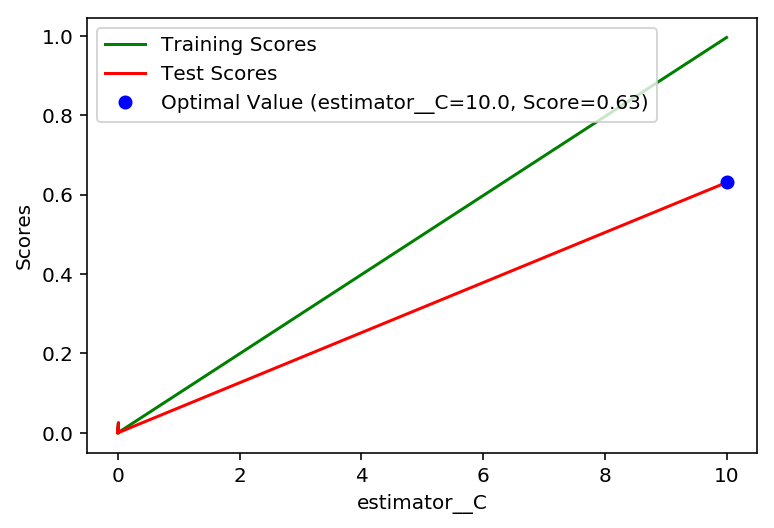

In [25]:
print(f'\nF1_Score of the Optimal Classifier with parameters-{classifier.best_params_} is {round(classifier.best_score_*100, 2)} %')
plot_scores(classifier, 'estimator__C')

In [26]:
# with open('classifier_preds.pkl', 'wb') as f:
#     pickle.dump(predictions, f)

# with open('association_preds.pkl', 'wb') as f:
#     pickle.dump(predicted, f)

# with open('classifier.pkl', 'wb') as f:
#     pickle.dump(classifier, f)

In [27]:
predicted_vect = np.array(pred_tags_test.todense())
predictions_vect = np.array(predictions.todense())
print(predicted_vect.shape, predictions_vect.shape)

(2000, 5419) (2000, 5419)


In [28]:
%%time
final_predictions = []

for i in tqdm(range(predicted_vect.shape[0])):
    row = []
    for j in range(predicted_vect.shape[1]):
        if predicted_vect[i,j] == 1 and predictions_vect[i,j] == 1:
#         if predicted_vect[i,j] == 1 or predictions_vect[i,j] == 1:
            row.append(1)
        else:
            row.append(0)
    final_predictions.append(row)

final = sparse.csr_matrix(final_predictions)
print(f1_score(actual_tags_test, final, average='micro'))

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 288.52it/s]


0.750945434900054
Wall time: 7.5 s
